In [1]:
import os 
from datetime import datetime
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 16

In [2]:
# load dataset
wd = '/Users/ewenwang/OneDrive/IBM/Project_ICBC/code_wu'
os.chdir(wd)
DataFile = 'dataset_new.csv'
dataset = pd.read_csv(DataFile, low_memory=False)
dtrain, dtest = train_test_split(dataset, test_size=0.333, random_state=7)

target = 'loan_status'
predictors = [x for x in dataset.columns if x not in [target]]

In [3]:
def loaddata(wd, DataFile, seed = 7, test_size = 0.33):
    """ Load data and split it into training and test datasets """
    
    dataset = pd.read_csv(DataFile, low_memory=False)
    target = 'loan_status'
    predictors = [x for x in dataset.columns if x not in [target]]
    dtrain, dtest = train_test_split(dataset, test_size=test_size, random_state=seed)
    
    return dtrain, dtest

In [4]:
def modelfit(lgbm, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """ Fit models w/ parameters """    
    if useTrainCV:
        lgb_param = lgbm.get_params()
        lgbtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values)
        lgbtest = lgb.Dataset(dtest[predictors].values, label=dtest[target].values, reference=lgbtrain)
        cvresult = lgb.cv(lgb_param, 
                          lgbtrain, 
                          num_boost_round=lgbm.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)
        cv = pd.DataFrame(cvresult)
        lgbm.set_params(n_estimators=cv.shape[0])
        print(cv.tail(10))
    
    lgbm.fit(dtrain[predictors], dtrain[target], eval_metric='auc')

    dtrain_predictions = lgbm.predict(dtrain[predictors])
    dtest_predictions = lgbm.predict(dtest[predictors])
    dtrain_predprob = lgbm.predict_proba(dtrain[predictors])[:,1]
    dtest_predprob = lgbm.predict_proba(dtest[predictors])[:,1]
        
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target], dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)) 
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest[target], dtest_predprob))
    print(classification_report(dtest[target], dtest_predictions))
    
    lgb.plot_importance(lgbm, figsize=(12, 16), grid=False)
    return None

In [5]:
lgbm = LGBMClassifier(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=3, 
    learning_rate=0.01, 
    n_estimators=1000, 
    subsample_for_bin=200000, 
    objective='binary', 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=1, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=2017, 
    n_jobs=-1, 
    silent=True
)


Model Report
Accuracy : 0.9719
AUC Score (Train): 0.770596
AUC Score (Test): 0.698540
0:00:14.903694


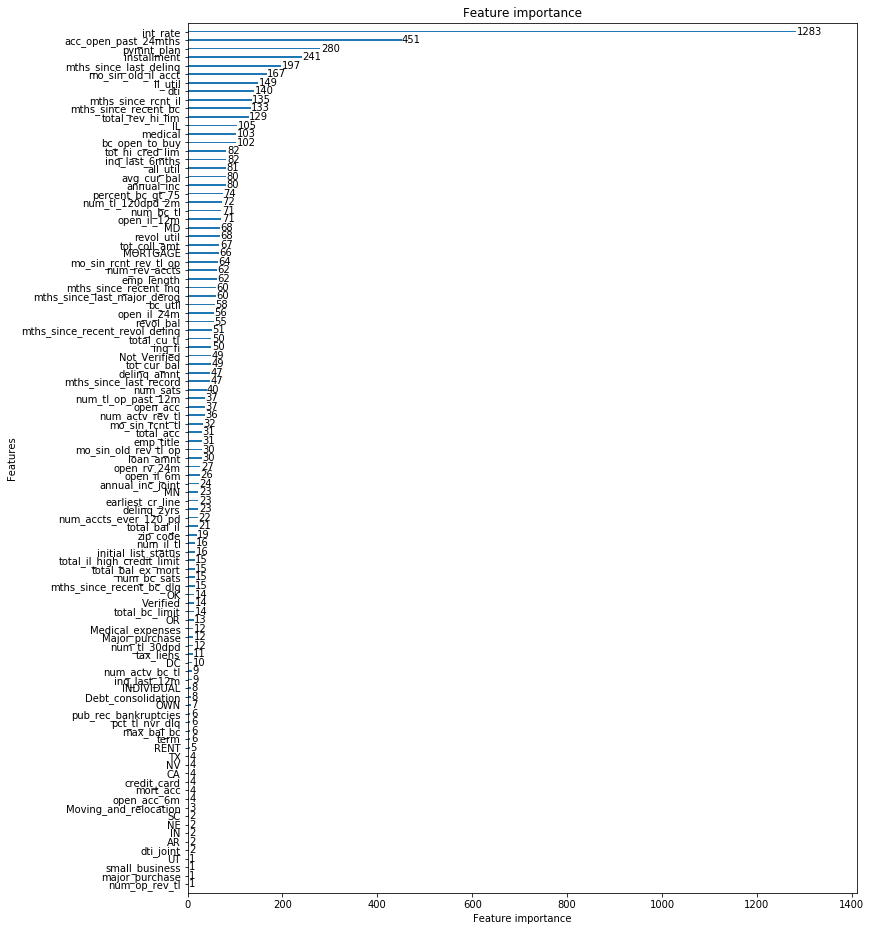

In [6]:
st = datetime.now()
modelfit(lgbm, dtrain, dtest, predictors, useTrainCV=False)
print(datetime.now()-st)


Model Report
Accuracy : 0.6633
AUC Score (Train): 0.745096
AUC Score (Test): 0.713167
             precision    recall  f1-score   support

          0       0.98      0.66      0.79     30826
          1       0.05      0.63      0.09       879

avg / total       0.96      0.65      0.77     31705

0:00:34.460310


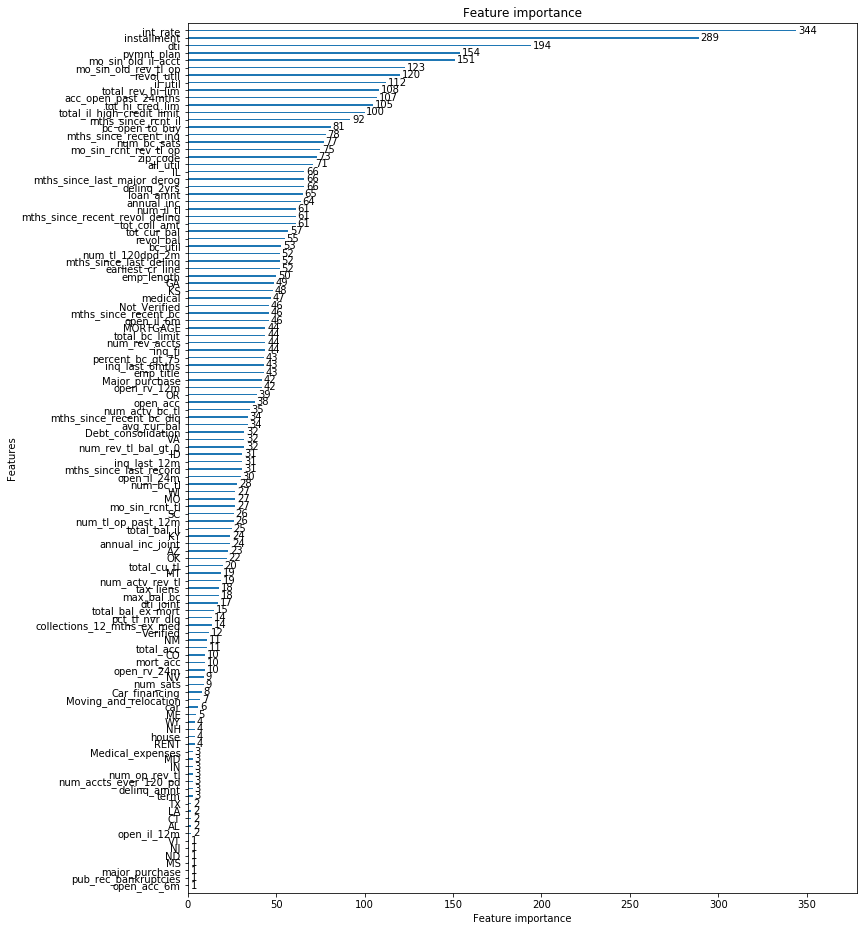

In [12]:
lgbm = LGBMClassifier(
    learning_rate=0.01, 
    n_estimators=5000, 
    objective='binary', 
    max_depth=1, 
    subsample=0.77, 
    colsample_bytree=0.73,
    is_unbalance=True,
    num_leaves=7,
    seed=2)

st = datetime.now()
modelfit(lgbm, dtrain, dtest, predictors, useTrainCV=False)
print(datetime.now()-st)

In [7]:
import gossipcat as gc

In [8]:
help(gc.report_CM)

Help on function report_CM in module gossipcat.core:

report_CM(classifier, test, predictors, target)
    A report on confusion matrix.
    
    Reports the recall rate of the classifier on test data and plots out 
    confusion matrix.
    
    Args:
        classifier: A classifier to report.
        test: A test set of your machine learning project.
        predictors: The predictors of your dataset.
        target: The target variable in your dataset; limited to binary.




predicting...

Model Report
Recall metric in the testing dataset:  0.634812286689


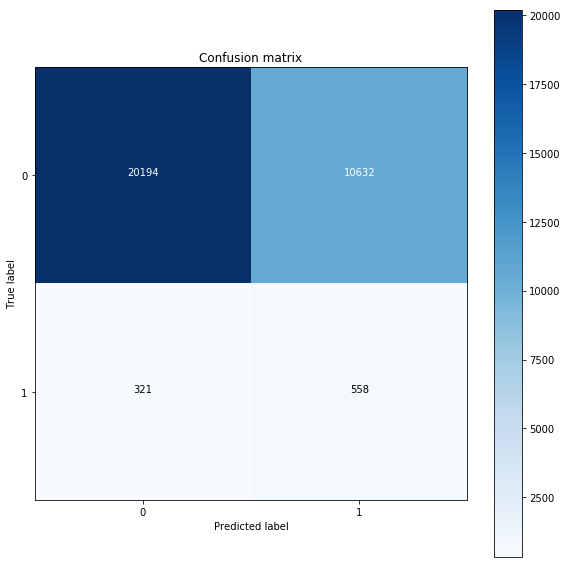

In [13]:
gc.report_CM(lgbm, dtest, predictors, target)


Model Report
Accuracy : 0.9717
AUC Score (Train): 0.740113
AUC Score (Test): 0.716518
             precision    recall  f1-score   support

          0       0.97      1.00      0.99     30826
          1       1.00      0.02      0.05       879

avg / total       0.97      0.97      0.96     31705

0:00:35.205912

predicting...

Model Report
Recall metric in the testing dataset:  0.0238907849829


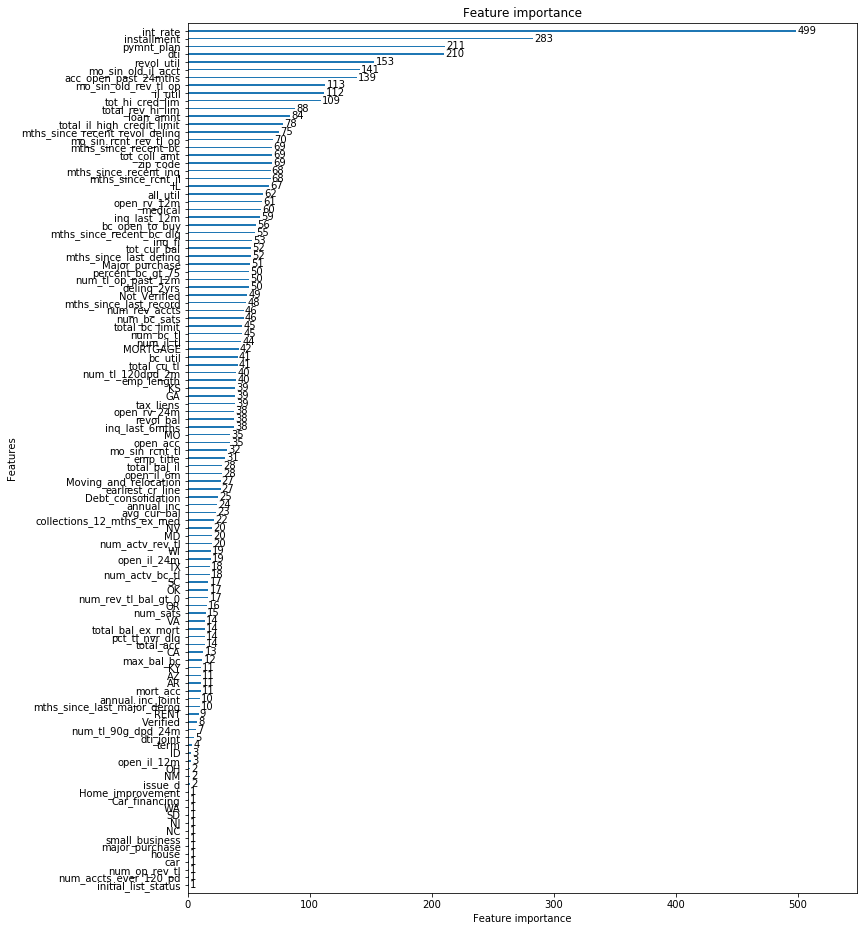

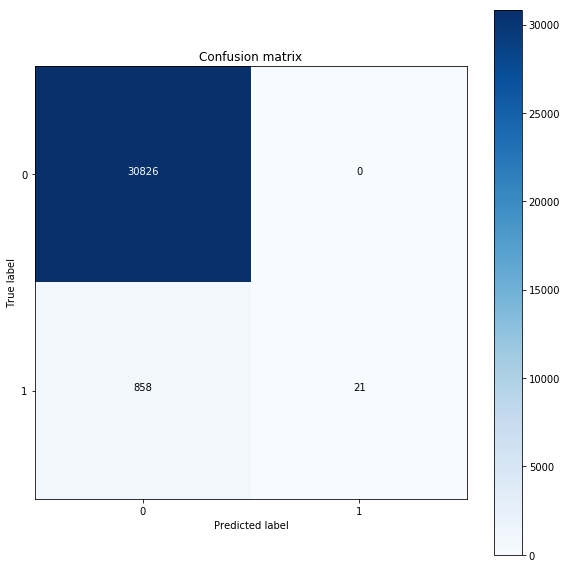

In [16]:
lgbm_b = LGBMClassifier(
    learning_rate=0.01, 
    n_estimators=5000, 
    objective='binary', 
    max_depth=1, 
    subsample=0.77, 
    colsample_bytree=0.73,
    num_leaves=7,
    seed=2)

st = datetime.now()
modelfit(lgbm_b, dtrain, dtest, predictors, useTrainCV=False)
print(datetime.now()-st)

gc.report_CM(lgbm_b, dtest, predictors, target)


predicting...

Model Report
Average Precision: 0.0939


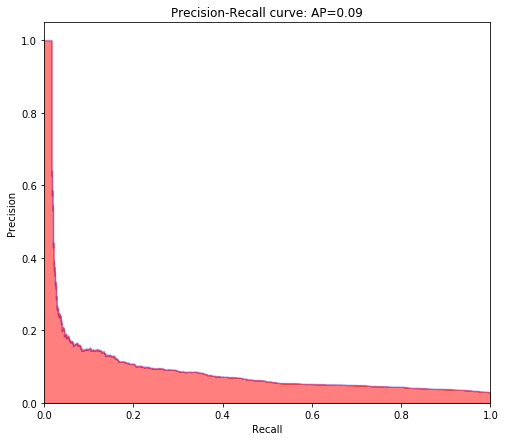

In [14]:
gc.report_PR(lgbm, dtest, predictors, target)